<a href="https://colab.research.google.com/github/ivyar/DA_labs/blob/main/Lab%204/DA_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os, io, random
import string
import re
import keras
from keras import layers
import tensorflow as tf

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import PIL.Image
import time
import functools
from keras.preprocessing import image

In [ ]:
with io.open('/content/Lys_mykyta.txt', encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
print("Corpus length:", len(text))

Corpus length: 86526


In [ ]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 49


In [ ]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 28829


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 5
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

226/226 [==============================] - 29s 120ms/step - loss: 2.7235

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "я кам'яне.  там лежить той скарб забутий"
...Generated:   – – за з брови з брививи – від брови за бровити за в з мовсь – від – та в стро з мавсь – – – мав на повили за трив я мити з – дро з мовсь і ду митити не провави – – та бо в на мись – провити – – прово за мити за ври замити – му вись – – бров, – – – – – – во дро вись – та мити з бровити скрав він зарови – – мити за мити з бривити він – він скривити – – та мити в на го вся в в не з бровити – – за з
-
...Diversity: 0.5
...Generating with seed: "я кам'яне.  там лежить той скарб забутий"
...Generated:  , – – та давсьи зароста за а ну не вобу вори мити: – мити, – а шобули завли дровами – – вій з васки с дріла в стово ці на прови він а дров від оро! – – те за зались а то вор віс прив. – – мена стує, – на з тожли – в на в на зало з орочи – а прожи ні пропівсь – за зажу, – з гровну, – що мит

Пункт 2

In [10]:
sum_1 = pipeline("summarization", model="knkarthick/MEETING-SUMMARY-BART-LARGE-XSUM-SAMSUM-DIALOGSUM-AMI")

config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [13]:
text_1 = "Asthma — a disease of the lower airways — is thought to affect as much as 5% of cats. There is some debate about what causes cat asthma, but most experts think it’s caused by an allergic reaction to something the cat breathes in. When a cat inhales allergens, the immune system may react and create inflammation. Inflammatory cells may develop in the airways and produce chemicals that create more inflammation."
result = sum_1(text_1, max_length=25, min_length=5)
print(result)

[{'summary_text': 'According to most experts, cat asthma is caused by an allergic reaction to something the cat breathes in'}]


In [14]:
sum_2 = pipeline("summarization", model='ukr-models/uk-summarizer')

In [17]:
text_2 = "Астма кішок — хронічна недуга нижніх дихальних шляхів. Причиною вважається присутність алергену, що викликає звуження бронхіолу. Цим фактором може бути пил наповнювача для лотка, глисти, аерозоль, парфум, пилок, тютюновий дим. Симптоми можуть бути різними. Деякі тварини кашляють регулярно, інші — нападами, з блювотою та відкашлюванням піни."
sum_2(text_2, max_length=28, min_length=5)

[{'summary_text': 'У кішок є рідкісна хвороба, яка може призвести до кашлю..'}]

Пункт 3

In [18]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [19]:
content_path = 'kitten.jpg'
style_path = 'kubizm.jpg'

In [20]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [21]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

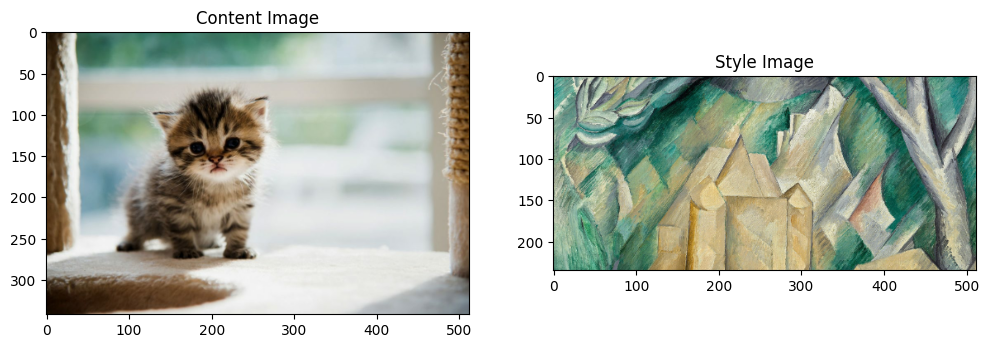

In [22]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [23]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [24]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [25]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [26]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [27]:
extractor = StyleContentModel(style_layers, content_layers)

In [28]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [29]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [30]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [32]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

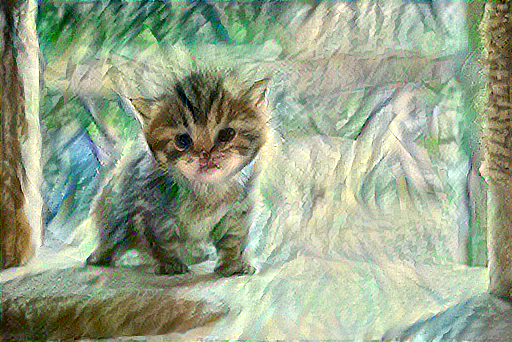

Train step: 200


In [33]:
epochs = 2
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))